In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [10]:
retail=pd.read_csv("online_retail.csv")
retail.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [14]:
data=retail

In [16]:
# Get the minimum and maximum date
min_date = pd.to_datetime(retail['InvoiceDate'].min())
max_date = pd.to_datetime(retail['InvoiceDate'].max())
duration = max_date - min_date

print(f"Min Date: {min_date}")
print(f"Max Date: {max_date}")
print(f"Duration: {duration.days} days")

Min Date: 2009-12-01 07:45:00
Max Date: 2011-12-09 12:50:00
Duration: 738 days


In [18]:
retail.shape

(1067371, 8)

Data Cleaning

In [20]:
# percentage count of null values
df_null=100*(retail.isnull().sum())/len(retail)
df_null

Invoice         0.000000
StockCode       0.000000
Description     0.410541
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.766873
Country         0.000000
dtype: float64

In [22]:
# Dropping rows having missing values
retail.dropna(inplace=True,axis=0)

In [24]:
retail.shape

(824364, 8)

In [26]:
print("Number of duplicates before cleaning:",retail.duplicated().sum())
retail = retail.drop_duplicates(keep="first")
print("Number of duplicates after cleaning:",retail.duplicated().sum())

Number of duplicates before cleaning: 26479
Number of duplicates after cleaning: 0


In [28]:
retail.shape

(797885, 8)

In [30]:
# Removing returned products (Invoice numbers starting with C) from the data set
retail = retail[~retail["Invoice"].str.contains("C", na = False)]

# Removing missing values from the dataset
retail.dropna(inplace = True)

In [32]:
retail.shape

(779495, 8)

In [34]:
retail['InvoiceDate']=pd.to_datetime(retail['InvoiceDate'])

In [523]:
retail.shape

(779495, 8)

In [36]:
#changing the datatype of customer ID
retail['Customer ID']=retail['Customer ID'].astype(str)

In [38]:
retail['Customer ID'].nunique()

5881

In [40]:
#Calculatong recency, frequency and monetary
retail['Amount']=retail['Quantity']*retail['Price']
rfm_m=retail.groupby('Customer ID')['Amount'].sum()
rfm_m=rfm_m.reset_index()
print(rfm_m.head())
print(rfm_m.shape)

  Customer ID    Amount
0     12346.0  77556.46
1     12347.0   4921.53
2     12348.0   2019.40
3     12349.0   4428.69
4     12350.0    334.40
(5881, 2)


In [42]:
# Separate positive (purchases) and negative (returns)
purchase_df = rfm_m[rfm_m["Amount"] >= 0] 
refund_df = rfm_m[rfm_m["Amount"] < 0]

In [44]:
purchase_df.shape

(5881, 2)

In [46]:
refund_df.shape

(0, 2)

In [150]:
#data[data['Quantity']<0]
retail[(retail['Quantity'] >0) & (retail['Invoice'].astype(str).str.contains('C'))]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount


There are no customers with canceled transactions having a positive quantity, which confirms that the collected data is accurate.

In [50]:
print("purchase_df : ",purchase_df)
print("refund_df : ",refund_df)

purchase_df :       Customer ID    Amount
0        12346.0  77556.46
1        12347.0   4921.53
2        12348.0   2019.40
3        12349.0   4428.69
4        12350.0    334.40
...          ...       ...
5876     18283.0   2664.90
5877     18284.0    461.68
5878     18285.0    427.00
5879     18286.0   1296.43
5880     18287.0   4182.99

[5881 rows x 2 columns]
refund_df :  Empty DataFrame
Columns: [Customer ID, Amount]
Index: []


In [170]:
customer_df = purchase_df.merge(refund_df, on="Customer ID", how="outer", suffixes=("_purchase", "_refund"))

In [178]:
customer_df.fillna(0,inplace=True)

In [180]:
customer_df

,Customer ID,Amount_purchase,Amount_refund
0,12346.0,77556.46,0.0
1,12347.0,4921.53,0.0
2,12348.0,2019.40,0.0
3,12349.0,4428.69,0.0
4,12350.0,334.40,0.0
...,...,...,...
5876,18283.0,2664.90,0.0
5877,18284.0,461.68,0.0
5878,18285.0,427.00,0.0
5879,18286.0,1296.43,0.0


In [184]:
customer_df['TotalAmount']=customer_df['Amount_purchase']+customer_df['Amount_refund']
customer_df

,Customer ID,Amount_purchase,Amount_refund,TotalAmount
0,12346.0,77556.46,0.0,77556.46
1,12347.0,4921.53,0.0,4921.53
2,12348.0,2019.40,0.0,2019.40
3,12349.0,4428.69,0.0,4428.69
4,12350.0,334.40,0.0,334.40
...,...,...,...,...
5876,18283.0,2664.90,0.0,2664.90
5877,18284.0,461.68,0.0,461.68
5878,18285.0,427.00,0.0,427.00
5879,18286.0,1296.43,0.0,1296.43


In [189]:
customer_df

,Customer ID,Amount_purchase,Amount_refund,TotalAmount
0,12346.0,77556.46,0.0,77556.46
1,12347.0,4921.53,0.0,4921.53
2,12348.0,2019.40,0.0,2019.40
3,12349.0,4428.69,0.0,4428.69
4,12350.0,334.40,0.0,334.40
...,...,...,...,...
5876,18283.0,2664.90,0.0,2664.90
5877,18284.0,461.68,0.0,461.68
5878,18285.0,427.00,0.0,427.00
5879,18286.0,1296.43,0.0,1296.43


In [191]:
customer_df.isnull().sum()

Customer ID        0
Amount_purchase    0
Amount_refund      0
TotalAmount        0
dtype: int64

In [197]:
customer_df.rename(columns={"TotalAmount": "Monetary"}, inplace=True)

In [199]:
rfm_f=retail.groupby('Customer ID')['Invoice'].count()
rfm_f=rfm_f.reset_index()
rfm_f.columns=['Customer ID','Frequency']
rfm_f.head()
rfm_f.shape

(5881, 2)

In [195]:
customer_df = customer_df.merge(rfm_f, on="Customer ID", how="left")
customer_df

,Customer ID,Amount_purchase,Amount_refund,TotalAmount,Frequency
0,12346.0,77556.46,0.0,77556.46,34
1,12347.0,4921.53,0.0,4921.53,222
2,12348.0,2019.40,0.0,2019.40,51
3,12349.0,4428.69,0.0,4428.69,175
4,12350.0,334.40,0.0,334.40,17
...,...,...,...,...,...
5876,18283.0,2664.90,0.0,2664.90,938
5877,18284.0,461.68,0.0,461.68,28
5878,18285.0,427.00,0.0,427.00,12
5879,18286.0,1296.43,0.0,1296.43,67


In [201]:
now=max(retail['InvoiceDate'])
now

Timestamp('2011-12-09 12:50:00')

In [203]:
rfm_r=now-retail.groupby('Customer ID')['InvoiceDate'].max()
rfm_r=rfm_r.reset_index()
rfm_r.columns=['Customer ID','Recency']
rfm_r['Recency'] = rfm_r['Recency'].dt.days
rfm_r

,Customer ID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
5876,18283.0,3
5877,18284.0,431
5878,18285.0,660
5879,18286.0,476


In [205]:
customer_df = customer_df.merge(rfm_r, on="Customer ID", how="left")
customer_df

,Customer ID,Amount_purchase,Amount_refund,Monetary,Frequency,Recency
0,12346.0,77556.46,0.0,77556.46,34,325
1,12347.0,4921.53,0.0,4921.53,222,1
2,12348.0,2019.40,0.0,2019.40,51,74
3,12349.0,4428.69,0.0,4428.69,175,18
4,12350.0,334.40,0.0,334.40,17,309
...,...,...,...,...,...,...
5876,18283.0,2664.90,0.0,2664.90,938,3
5877,18284.0,461.68,0.0,461.68,28,431
5878,18285.0,427.00,0.0,427.00,12,660
5879,18286.0,1296.43,0.0,1296.43,67,476


In [212]:
customer_df.drop(columns={'Amount_purchase','Amount_refund'},inplace=True)

In [214]:
#again, check for negative monetary values
customer_df[customer_df['Monetary']<0]

,Customer ID,Monetary,Frequency,Recency


Customers with a negative monetary value usually indicate returns, refunds, or fraudulent activities. Since your existing categories—Strangers, Barnacles, Butterflies, and True Friends—are based on loyalty and spending behavior, these customers don’t fit neatly into any of them.

Text(0.5, 0, 'Attributes')

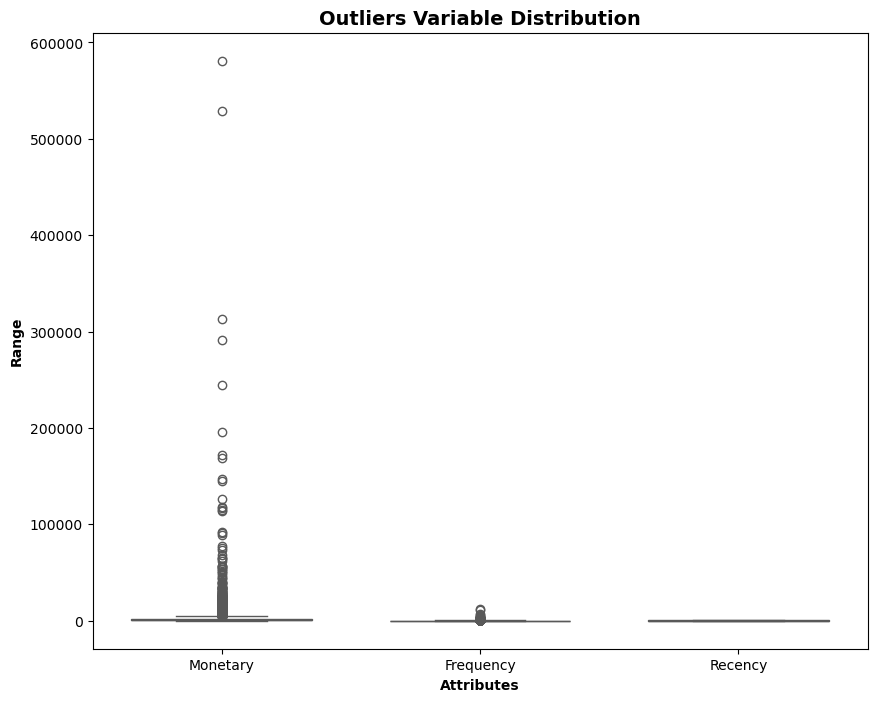

In [216]:
attributes=['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize']=[10,8]
sns.boxplot(data=customer_df[attributes],orient='v',palette='Set2',whis=1.5,saturation=1,width=0.7)
plt.title("Outliers Variable Distribution",fontsize=14,fontweight='bold')
plt.ylabel("Range",fontweight='bold')
plt.xlabel("Attributes",fontweight='bold')

Since monetary values naturally vary across customers, removing high-value outliers without proper reasoning might lead to incorrect conclusions.

In [218]:
customer_df

,Customer ID,Monetary,Frequency,Recency
0,12346.0,77556.46,34,325
1,12347.0,4921.53,222,1
2,12348.0,2019.40,51,74
3,12349.0,4428.69,175,18
4,12350.0,334.40,17,309
...,...,...,...,...
5876,18283.0,2664.90,938,3
5877,18284.0,461.68,28,431
5878,18285.0,427.00,12,660
5879,18286.0,1296.43,67,476


In [220]:
rfm_scores=customer_df.copy()

In [222]:
rfm_scores["RecencyScore"]  = pd.qcut(rfm_scores["Recency"], 10, labels=[10,9,8,7,6,5, 4, 3, 2, 1])
rfm_scores["FrequencyScore"] = pd.qcut(rfm_scores["Frequency"].rank(method="first"), 10, labels=[1, 2, 3, 4, 5,6,7,8,9,10])
rfm_scores["MonetaryScore"] = pd.qcut(rfm_scores["Monetary"], 10, labels=[1, 2, 3, 4, 5,6,7,8,9,10])

In [224]:
rfm_scores.dtypes

Customer ID         object
Monetary           float64
Frequency            int64
Recency              int64
RecencyScore      category
FrequencyScore    category
MonetaryScore     category
dtype: object

In [226]:
rfm_scores['RecencyScore'] = pd.to_numeric(rfm_scores['RecencyScore'], errors='coerce')
rfm_scores['FrequencyScore'] = pd.to_numeric(rfm_scores['FrequencyScore'], errors='coerce')
rfm_scores['MonetaryScore'] = pd.to_numeric(rfm_scores['MonetaryScore'], errors='coerce')

In [228]:
rfm_scores[['Recency','RecencyScore']] 


,Recency,RecencyScore
0,325,3
1,1,10
2,74,6
3,18,9
4,309,4
...,...,...
5876,3,10
5877,431,2
5878,660,1
5879,476,2


In [230]:
customer_df_with_rfm_scores=rfm_scores.copy()

In [232]:
customer_df_with_rfm_scores

,Customer ID,Monetary,Frequency,Recency,RecencyScore,FrequencyScore,MonetaryScore
0,12346.0,77556.46,34,325,3,4,10
1,12347.0,4921.53,222,1,10,9,9
2,12348.0,2019.40,51,74,6,5,8
3,12349.0,4428.69,175,18,9,9,9
4,12350.0,334.40,17,309,4,3,3
...,...,...,...,...,...,...,...
5876,18283.0,2664.90,938,3,10,10,8
5877,18284.0,461.68,28,431,2,4,4
5878,18285.0,427.00,12,660,1,2,4
5879,18286.0,1296.43,67,476,2,6,7


In [234]:
rfm_scores.drop(columns={'Monetary','Frequency','Recency'},inplace=True)

In [238]:
rfm_scores.head()

,Customer ID,RecencyScore,FrequencyScore,MonetaryScore
0,12346.0,3,4,10
1,12347.0,10,9,9
2,12348.0,6,5,8
3,12349.0,9,9,9
4,12350.0,4,3,3


In [241]:
rfm_scores.dtypes

Customer ID       object
RecencyScore       int64
FrequencyScore     int64
MonetaryScore      int64
dtype: object

In [243]:
x=rfm_scores.loc[:,['RecencyScore','FrequencyScore','MonetaryScore']]

In [245]:
x

,RecencyScore,FrequencyScore,MonetaryScore
0,3,4,10
1,10,9,9
2,6,5,8
3,9,9,9
4,4,3,3
...,...,...,...
5876,10,10,8
5877,2,4,4
5878,1,2,4
5879,2,6,7


In [250]:
kmeans=KMeans(n_clusters=4,max_iter=50)
kmeans.fit(x)

KMeans(max_iter=50, n_clusters=4)

In [252]:
kmeans.labels_

array([2, 0, 2, ..., 3, 2, 0])

In [254]:
set(kmeans.labels_)

{0, 1, 2, 3}

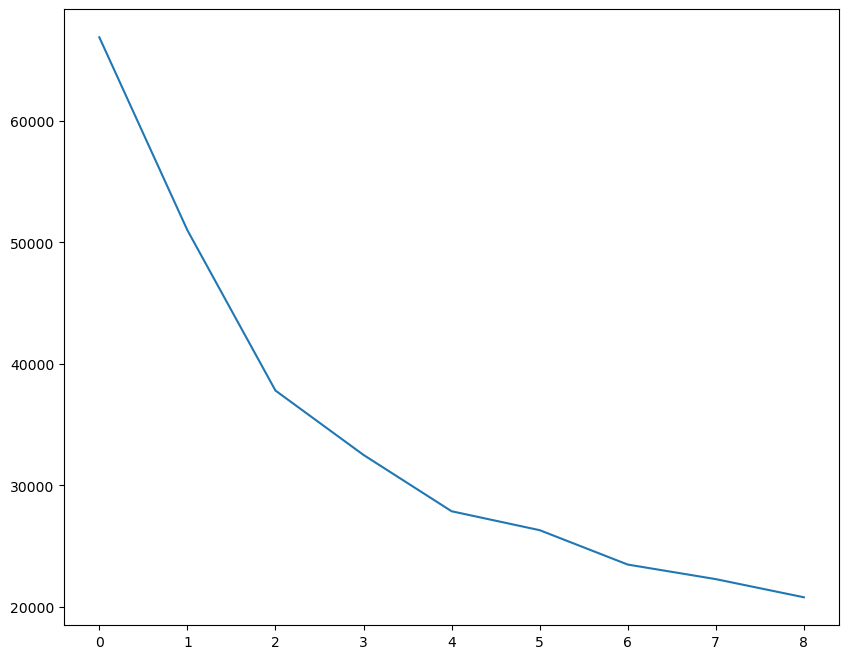

In [256]:
wcss=[]
range_n_clusters=[2,3,4,5,6,7,8,9,10]
for num_clusters in range_n_clusters:
    kmeans=KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(x)

    wcss.append(kmeans.inertia_)

#plot the ssds for each n_clusters
plt.plot(wcss)

In [258]:
wcss

[66864.5827049068,
 50994.19163278946,
 37804.35063014136,
 32508.96441092549,
 27876.71653373265,
 26319.911714147627,
 23491.541014133887,
 22293.026157392986,
 20800.207491861536]

In [260]:
kmeans=KMeans(n_clusters=4,max_iter=300,random_state=42)
kmeans.fit_predict(x)
kmeans

KMeans(n_clusters=4, random_state=42)

In [262]:
# Fit the model on your RFM dataset
rfm_scores['Cluster']=kmeans.fit_predict(x)

# View the first few rows with cluster labels
rfm_scores.head(20)


,Customer ID,RecencyScore,FrequencyScore,MonetaryScore,Cluster
0,12346.0,3,4,10,1
1,12347.0,10,9,9,3
2,12348.0,6,5,8,1
3,12349.0,9,9,9,3
4,12350.0,4,3,3,2
5,12351.0,3,3,3,2
6,12352.0,7,7,8,3
7,12353.0,4,3,3,2
8,12354.0,4,6,6,1
9,12355.0,4,4,6,1


In [352]:
rfm_scores.tail()

,Customer ID,RecencyScore,FrequencyScore,MonetaryScore,Cluster
5876,18283.0,10,10,8,3
5877,18284.0,2,4,4,2
5878,18285.0,1,2,4,2
5879,18286.0,2,6,7,1
5880,18287.0,7,8,9,3


In [266]:
cluster_stats=rfm_scores.groupby('Cluster').agg({'RecencyScore':['mean','std','count'],
                                         'FrequencyScore':['mean','std','count'],
                                          'MonetaryScore':['mean','std','count']})
cluster_stats

RecencyScore                 FrequencyScore                  \
                mean       std count           mean       std count   
Cluster                                                               
0           7.631951  1.479400  1133       3.956752  1.751547  1133   
1           3.914769  1.516118  1361       6.379133  1.630673  1361   
2           2.567600  1.382264  1679       2.570578  1.373898  1679   
3           8.310890  1.469055  1708       8.700234  1.239489  1708   

        MonetaryScore                  
                 mean       std count  
Cluster                                
0            4.052074  1.711509  1133  
1            6.558413  1.569846  1361  
2            2.448481  1.310836  1679  
3            8.614169  1.299077  1708

3:True_Friends, 2:Strangers, 1:Butterflies, 0: Barnacles

In [268]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(x, rfm_scores['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.37956693810196845


In [135]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(x, rfm_scores['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 0.9531885984549742


In [139]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(x, rfm_scores['Cluster'])
print(f'Calinski-Harabasz Score: {ch_score}')


Calinski-Harabasz Score: 5609.415779382291


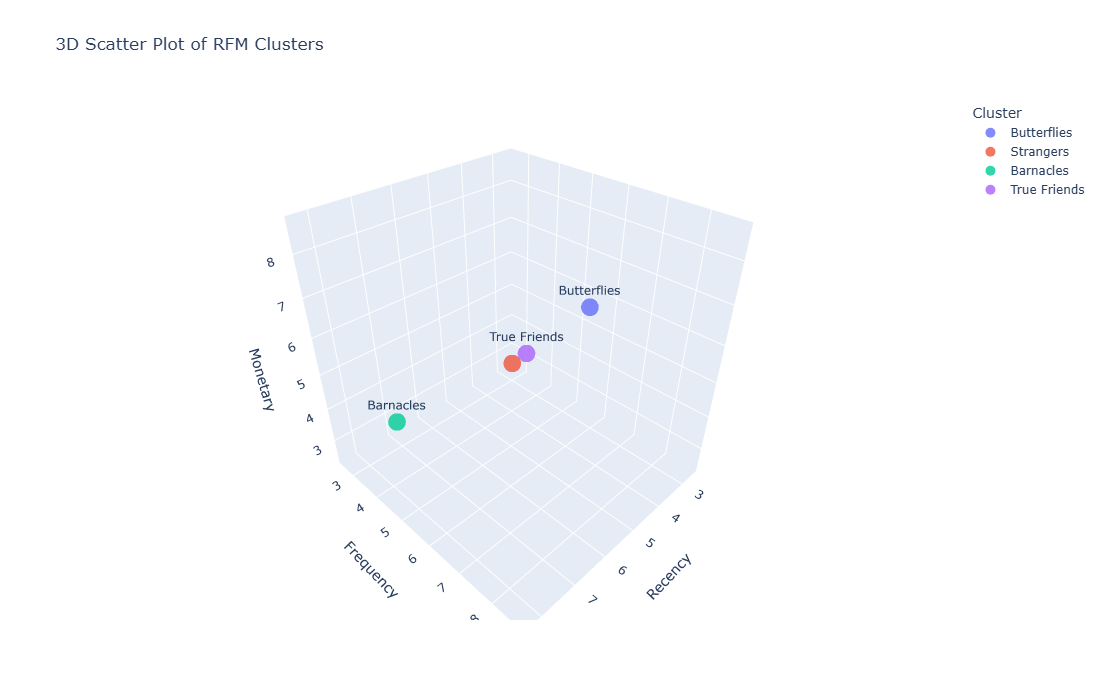

In [148]:
import plotly.express as px
import pandas as pd

# Sample RFM data (Replace this with your actual dataframe)
data = {
    'RecencyScore': [3.91, 2.56, 7.63, 8.31],
    'FrequencyScore': [6.37, 2.57, 3.95, 8.70],
    'MonetaryScore': [6.55, 2.44, 4.05, 8.61],
    'Cluster': ['Butterflies', 'Strangers', 'Barnacles','True Friends']
}

rfm_df = pd.DataFrame(data)

# 3D Scatter Plot
fig = px.scatter_3d(rfm_df, x='RecencyScore', y='FrequencyScore', z='MonetaryScore', 
                     color='Cluster', text='Cluster',
                     title='3D Scatter Plot of RFM Clusters', 
                     labels={'RecencyScore': 'Recency', 'FrequencyScore': 'Frequency', 'MonetaryScore': 'Monetary'},height=700)

fig.update_traces(marker=dict(size=10, opacity=0.8))
fig.show()

In [270]:
import pickle

with open("model.pkl", "wb") as file:
    pickle.dump(kmeans, file)


In [289]:
customer_with_refund=customer_df[customer_df['Monetary']<0].shape[0]
#type(customer_with_refund[0])
customer_with_refund

0